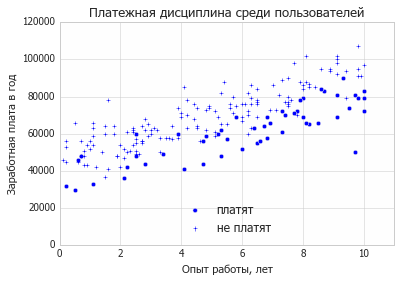

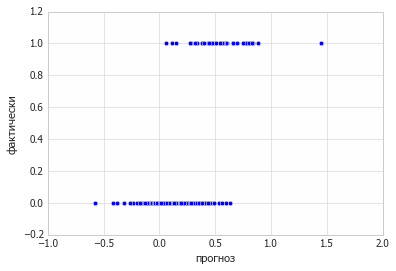

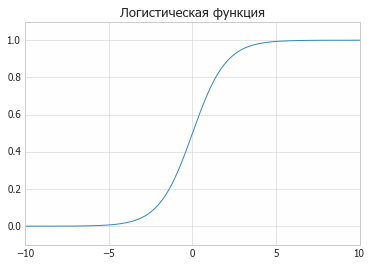

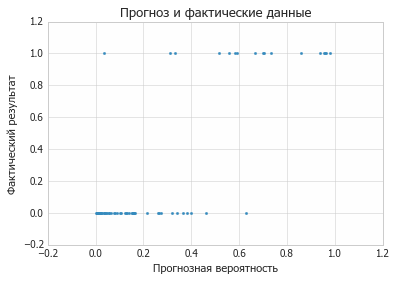

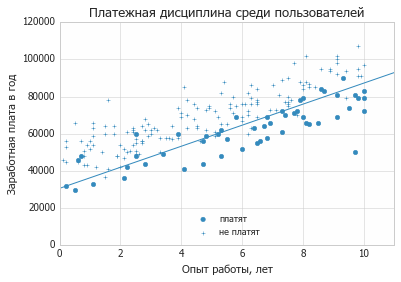

In [8]:
# -*- coding: utf-8 -*-
"""
Глава 16, рис. 1_5
"""

import sys
sys.path.append("../../code-python3-ru")

import numpy as np
import math, random

from collections import Counter
from functools import partial, reduce 
from lib.statistics import mean, variance, standard_deviation
from lib.linear_algebra import shape, get_column, make_matrix, dot
from lib.multiple_regression import estimate_beta, predict
from lib.logistic_regression import logistic

import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline  

mpl.style.use('ggplot')  
mpl.style.use('seaborn-whitegrid')  
mpl.rcParams['axes.facecolor'] = u'fefefe'
#mpl.rcParams.update({'font.family': 'Ubuntu Condensed'})   
mpl.rcParams.update({'font.family': 'Tahoma'})

    
def scale(data_matrix):
    num_rows, num_cols = shape(data_matrix)
    means = [mean(get_column(data_matrix,j))
             for j in range(num_cols)]
    stdevs = [standard_deviation(get_column(data_matrix,j))
              for j in range(num_cols)]
    return means, stdevs

def rescale(data_matrix):
    """нормализует входящие данные так, чтобы каждый столбец
    имел нулевое среднее и стандартное отклонение равное 1
    игнорирует столбцы без отклонения"""
    means, stdevs = scale(data_matrix)

    def rescaled(i, j):
        if stdevs[j] > 0:
            return (data_matrix[i][j] - means[j]) / stdevs[j]
        else:
            return data_matrix[i][j]

    num_rows, num_cols = shape(data_matrix)
    return make_matrix(num_rows, num_cols, rescaled)


def split_data(data, prob):
    """разбиение данных на части [prob, 1 - prob]"""
    results = [], []
    for row in data:
        results[0 if random.random() < prob else 1].append(row)
    return results

def train_test_split(x, y, test_pct):
    data = list(zip(x, y))                        # объединить соответствующие значения
    train, test = split_data(data, 1 - test_pct)  # разбить список пар
    x_train, y_train = list(zip(*train))          # трюк с разъединением списков
    x_test, y_test = list(zip(*test))
    return x_train, x_test, y_train, y_test


data = [(0.7,48000,1),(1.9,48000,0),(2.5,60000,1),(4.2,63000,0),(6,76000,0),
        (6.5,69000,0),(7.5,76000,0),(8.1,88000,0),(8.7,83000,1),(10,83000,1),
        (0.8,43000,0),(1.8,60000,0),(10,79000,1),(6.1,76000,0),(1.4,50000,0),
        (9.1,92000,0),(5.8,75000,0),(5.2,69000,0),(1,56000,0),(6,67000,0),
        (4.9,74000,0),(6.4,63000,1),(6.2,82000,0),(3.3,58000,0),(9.3,90000,1),
        (5.5,57000,1),(9.1,102000,0),(2.4,54000,0),(8.2,65000,1),(5.3,82000,0),
        (9.8,107000,0),(1.8,64000,0),(0.6,46000,1),(0.8,48000,0),(8.6,84000,1),
        (0.6,45000,0),(0.5,30000,1),(7.3,89000,0),(2.5,48000,1),(5.6,76000,0),
        (7.4,77000,0),(2.7,56000,0),(0.7,48000,0),(1.2,42000,0),(0.2,32000,1),
        (4.7,56000,1),(2.8,44000,1),(7.6,78000,0),(1.1,63000,0),(8,79000,1),
        (2.7,56000,0),(6,52000,1),(4.6,56000,0),(2.5,51000,0),(5.7,71000,0),
        (2.9,65000,0),(1.1,33000,1),(3,62000,0),(4,71000,0),(2.4,61000,0),
        (7.5,75000,0),(9.7,81000,1),(3.2,62000,0),(7.9,88000,0),(4.7,44000,1),
        (2.5,55000,0),(1.6,41000,0),(6.7,64000,1),(6.9,66000,1),(7.9,78000,1),
        (8.1,102000,0),(5.3,48000,1),(8.5,66000,1),(0.2,56000,0),(6,69000,0),
        (7.5,77000,0),(8,86000,0),(4.4,68000,0),(4.9,75000,0),(1.5,60000,0),
        (2.2,50000,0),(3.4,49000,1),(4.2,70000,0),(7.7,98000,0),(8.2,85000,0),
        (5.4,88000,0),(0.1,46000,0),(1.5,37000,0),(6.3,86000,0),(3.7,57000,0),
        (8.4,85000,0),(2,42000,0),(5.8,69000,1),(2.7,64000,0),(3.1,63000,0),
        (1.9,48000,0),(10,72000,1),(0.2,45000,0),(8.6,95000,0),(1.5,64000,0),
        (9.8,95000,0),(5.3,65000,0),(7.5,80000,0),(9.9,91000,0),(9.7,50000,1),
        (2.8,68000,0),(3.6,58000,0),(3.9,74000,0),(4.4,76000,0),(2.5,49000,0),
        (7.2,81000,0),(5.2,60000,1),(2.4,62000,0),(8.9,94000,0),(2.4,63000,0),
        (6.8,69000,1),(6.5,77000,0),(7,86000,0),(9.4,94000,0),(7.8,72000,1),
        (0.2,53000,0),(10,97000,0),(5.5,65000,0),(7.7,71000,1),(8.1,66000,1),
        (9.8,91000,0),(8,84000,0),(2.7,55000,0),(2.8,62000,0),(9.4,79000,0),
        (2.5,57000,0),(7.4,70000,1),(2.1,47000,0),(5.3,62000,1),(6.3,79000,0),
        (6.8,58000,1),(5.7,80000,0),(2.2,61000,0),(4.8,62000,0),(3.7,64000,0),
        (4.1,85000,0),(2.3,51000,0),(3.5,58000,0),(0.9,43000,0),(0.9,54000,0),
        (4.5,74000,0),(6.5,55000,1),(4.1,41000,1),(7.1,73000,0),(1.1,66000,0),
        (9.1,81000,1),(8,69000,1),(7.3,72000,1),(3.3,50000,0),(3.9,58000,0),
        (2.6,49000,0),(1.6,78000,0),(0.7,56000,0),(2.1,36000,1),(7.5,90000,0),
        (4.8,59000,1),(8.9,95000,0),(6.2,72000,0),(6.3,63000,0),(9.1,100000,0),
        (7.3,61000,1),(5.6,74000,0),(0.5,66000,0),(1.1,59000,0),(5.1,61000,0),
        (6.2,70000,0),(6.6,56000,1),(6.3,76000,0),(6.5,78000,0),(5.1,59000,0),
        (9.5,74000,1),(4.5,64000,0),(2,54000,0),(1,52000,0),(4,69000,0),
        (6.5,76000,0),(3,60000,0),(4.5,63000,0),(7.8,70000,0),(3.9,60000,1),
        (0.8,51000,0),(4.2,78000,0),(1.1,54000,0),(6.2,60000,0),(2.9,59000,0),
        (2.1,52000,0),(8.2,87000,0),(4.8,73000,0),(2.2,42000,1),(9.1,98000,0),
        (6.5,84000,0),(6.9,73000,0),(5.1,72000,0),(9.1,69000,1),(9.8,79000,1),]

data = list(map(list, data)) # преобразовать кортежи в списки


def paid_accounts():  #1
    fig = plt.figure()
    
    x = [[row[0],row[1]] for row in data
         if row[2]==0]
    
    x1, y1 = list(zip(*x)) 
    
    y = [[row[0],row[1]] for row in data
         if row[2]==1]
    x2, y2 = list(zip(*y))   
    
    plt.scatter(x2, y2, marker='o', label='платят')
    plt.scatter(x1, y1, marker='+', label='не платят')
    
    plt.xlim(0,11)
    plt.ylim(0,120000)
    plt.legend(loc=8)
    plt.xlabel("Опыт работы, лет", fontsize=11)
    plt.ylabel("Заработная плата в год", fontsize=11)
    plt.title("Платежная дисциплина среди пользователей", fontsize=13)
    plt.show()         
    #fig.savefig("fig_16-1", dpi=300, bbox_inches='tight', facecolor='w') 


def linear_reg():   #2
    fig = plt.figure()
    
    x = [[1] + row[:2] for row in data] # each element is [1, experience, salary]
    y = [row[2] for row in data]        # each element is paid_account
    
    rescaled_x = rescale(x)
    beta = estimate_beta(rescaled_x, y)  # [0.26, 0.43, -0.43]
    predictions = [predict(x_i, beta) for x_i in rescaled_x]
    
    plt.scatter(predictions, y) 
    plt.xlabel("прогноз", fontsize=11) 
    plt.ylabel("фактически", fontsize=11) 
    #plt.title("Линейная регрессия", fontsize=13)  # для предсказания оплаты аккаунтов
    plt.show()
    #fig.savefig("fig_16-2", dpi=300, bbox_inches='tight', facecolor='w') 

def logistic_func():   #3
    fig = plt.figure()
    
    X = np.linspace(-10, 10, 200)  
    Y = 1 / (1 + np.exp(-X))       # спрогнозированные значения
    plt.plot(X, Y, color="#348ABD")
    plt.axis([-10, 10, -0.1, 1.1]) 
    plt.title("Логистическая функция", fontsize=13)
    plt.show()   
    #fig.savefig("fig_16-3", dpi=300, bbox_inches='tight', facecolor='w') 

def logistic_predicted(): #4
    fig = plt.figure()
    
    #print("linear regression:")
    x = [[1] + row[:2] for row in data] # каждый элемент равен [1, стаж, зарплата]
    y = [row[2] for row in data]        # каждый элемент равен - оплаченный аккаунт
    
    rescaled_x = rescale(x)
    beta = estimate_beta(rescaled_x, y)
    
    random.seed(0)
    x_train, x_test, y_train, y_test = train_test_split(rescaled_x, y, 0.33)
    
    beta_hat = [-1.90, 4.05, -3.87]
    predictions = [logistic(dot(beta_hat, x_i)) for x_i in x_test] 
    predictions2 = [i for i, x_i in enumerate(x_test) if dot(beta_hat, x_i) > 0] 
    
    plt.scatter(predictions, y_test, marker='.', color="#348ABD")
    plt.xlabel("Прогнозная вероятность", fontsize=11) 
    plt.ylabel("Фактический результат", fontsize=11)
    plt.title("Прогноз и фактические данные", fontsize=13) 
    plt.show()
    #fig.savefig("fig_16-4", dpi=300, bbox_inches='tight', facecolor='w') 

    
def plot_decision_boundary():  #5
    fig = plt.figure()
    
    x = [[row[0],row[1]] for row in data if row[2]==0]
    x1, y1 = list(zip(*x)) #unzip(x)
    y = [[row[0],row[1]] for row in data if row[2]==1]
    x2, y2 = list(zip(*y))   

    x0 = [[1] + row[:2] for row in data] # каждый элемент равен [1, стаж, зарплата]
    y0 = [row[2] for row in data]        # каждый элемент равен - оплаченный аккаунт
    rescaled_x = rescale(x0)
    x_train, x_test, y_train, y_test = train_test_split(rescaled_x, y0, 0.33)
    
    # мой метод сегментации на классы по близости к значению x
    # получен путем перешкалирования данных data -> rescaled_x
    # и взятия скалярного произведения в абсолютном выражении abs(dot(beta_hat, x_i))
    # затем сортировке и взятии двух минимальных координат (точек) и вычислении дельты между ними: max - min
    # delta = (y2-y1) / (x2-x1) есть прирост в y (5660.378) на единицу изменения x
    # затем надо удлиннить линию до начала и конца оси x: 
    # мин.y = тек.мин.y - (5660.378*(тек.мин.x-мин.x))
    # макс.y = тек.макс.y + (5660.378*(макс.x-тек.макс.x))
    
    X5 = [0,data[91][0],data[152][0],11]
    Y5 = [30679.24, data[91][1],data[152][1],92943.39]  

    plt.plot(X5,Y5,'-', color="#348ABD")
    
    plt.scatter(x2, y2, marker='o', label='платят', color="#348ABD")
    plt.scatter(x1, y1, marker='+', label='не платят', color="#348ABD")

    plt.xlim(0,11)
    plt.ylim(0,120000)
    plt.legend(loc=8, fontsize=9)
    plt.xlabel("Опыт работы, лет", fontsize=11)
    plt.ylabel("Заработная плата в год", fontsize=11)
    plt.title("Платежная дисциплина среди пользователей", fontsize=13)
    plt.show()   
    #fig.savefig("fig_16-5", dpi=300, bbox_inches='tight', facecolor='w') 
    
    
paid_accounts()           #1
linear_reg()              #2
logistic_func()           #3
logistic_predicted()      #4
plot_decision_boundary()  #5